In [7]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [8]:
SEED = 1
BATCH_SIZE = 256
GAMMA = 0.99
LR = 0.0003
EPS = 1e-8

# set device
use_cuda = torch.cuda.is_available()
print('cuda:', use_cuda)
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

cuda: True


In [9]:
class ActorCriticNet(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.pol = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_space)
        )
        
        self.val = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        out = self.head(x)
        policy = self.pol(out).reshape(out.shape[0], -1)
        value = self.val(out).reshape(out.shape[0], 1)
        
        return policy, value

In [10]:
losses = []


def learn(net, tgt_net, optimizer, rep_memory):
    global action_space

    net.train()
    tgt_net.train()

    train_data = []
    train_data.extend(random.sample(rep_memory, BATCH_SIZE))
    dataloader = DataLoader(
        train_data, batch_size=BATCH_SIZE, pin_memory=use_cuda)
    # double DQN
    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.detach().to(device).long()
        _s_batch = _s.to(device).float()
        r_batch = r.detach().to(device).float()
        is_done = 1. - d.detach().reshape(BATCH_SIZE, 1).to(device).float()
        
        _q_batch = net(_s_batch)
        _a_batch = torch.argmax(_q_batch, dim=1)

        with torch.no_grad():
            _q_batch_tgt = tgt_net(_s_batch)
            done_mask = torch.cat(tuple(is_done for _ in range(action_space)), dim=1)
            _q_batch_tgt_masked = _q_batch_tgt * done_mask
            _q_best_tgt = _q_batch_tgt_masked[range(BATCH_SIZE), _a_batch]

        q_batch = net(s_batch)
        q_acting = q_batch[range(BATCH_SIZE), a_batch]

        # loss
        loss = ((r_batch + GAMMA*_q_best_tgt) - q_acting).pow(2).sum().mean()
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = target_net(state)
        action = torch.argmax(q)

    return action.item()

## Main

In [15]:
# make an environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
learn_start = 2000
memory_size = 50000
update_frq = 1
use_eps_decay = False
epsilon = 1.
eps_min = 0.001
decay_rate = 0.0001
n_eval = env.spec.trials

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_learned = False
is_solved = False

# make two nerual networks
new_net = ActorCriticNet(obs_space, action_space).to(device)
old_net = deepcopy(new)

# make a optimizer
optimizer = optim.Adam(new_net.parameters(), lr=LR, eps=EPS)

# make a memory
rep_memory = deque(maxlen=memory_size)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [13]:
use_cuda

True

In [14]:
env.spec.max_episode_steps

200

In [11]:
env.spec.trials

100

In [12]:
env.spec.reward_threshold

195.0

In [9]:
# play
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
        env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward
        
        if use_eps_decay:
            epsilon -= epsilon * decay_rate
            epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n============  Start Learning  ============\n')
            learn(net, target_net, optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            target_net.load_state_dict(net.state_dict())
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))

        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                torch.save(target_net.state_dict(),
                           f'./test/saved_models/{env.spec.id}_ep{i}_clear_model_dddqn.pt')
                break
env.close()

  1 Episode in    50 steps, reward -365.41
  2 Episode in   114 steps, reward -548.22
  3 Episode in   190 steps, reward -548.29
  4 Episode in   246 steps, reward -556.05
  5 Episode in   322 steps, reward -523.63
  6 Episode in   378 steps, reward -512.56
  7 Episode in   455 steps, reward -835.45
  8 Episode in   533 steps, reward -693.98
  9 Episode in   588 steps, reward -540.21
 10 Episode in   648 steps, reward -525.83
 11 Episode in   718 steps, reward -612.44
 12 Episode in   770 steps, reward -461.45
 13 Episode in   833 steps, reward -549.06
 14 Episode in   893 steps, reward -531.40
 15 Episode in   953 steps, reward -597.42
 16 Episode in  1008 steps, reward -500.84
 17 Episode in  1084 steps, reward -821.64
 18 Episode in  1151 steps, reward -550.73
 19 Episode in  1218 steps, reward -557.22
 20 Episode in  1297 steps, reward -811.03
 21 Episode in  1360 steps, reward -646.42
 22 Episode in  1416 steps, reward -522.84
 23 Episode in  1478 steps, reward -617.94
 24 Episode

192 Episode in 82961 steps, reward -78.44
193 Episode in 83961 steps, reward 56.47
194 Episode in 84961 steps, reward 6.79
195 Episode in 85085 steps, reward -91.19
196 Episode in 86085 steps, reward 93.93
197 Episode in 86718 steps, reward -325.64
198 Episode in 87718 steps, reward -130.21
199 Episode in 88718 steps, reward -12.17
200 Episode in 89308 steps, reward 101.36
201 Episode in 90308 steps, reward 78.96
202 Episode in 91308 steps, reward 55.18
203 Episode in 92308 steps, reward 53.87
204 Episode in 92539 steps, reward -100.29
205 Episode in 93539 steps, reward 54.15
206 Episode in 94077 steps, reward 183.91
207 Episode in 95077 steps, reward 47.86
208 Episode in 96077 steps, reward 33.52
209 Episode in 96367 steps, reward -112.07
210 Episode in 97367 steps, reward 89.09
211 Episode in 97770 steps, reward -96.69
212 Episode in 98268 steps, reward -181.57
213 Episode in 98494 steps, reward -305.74
214 Episode in 98922 steps, reward 226.16
215 Episode in 99591 steps, reward 111.

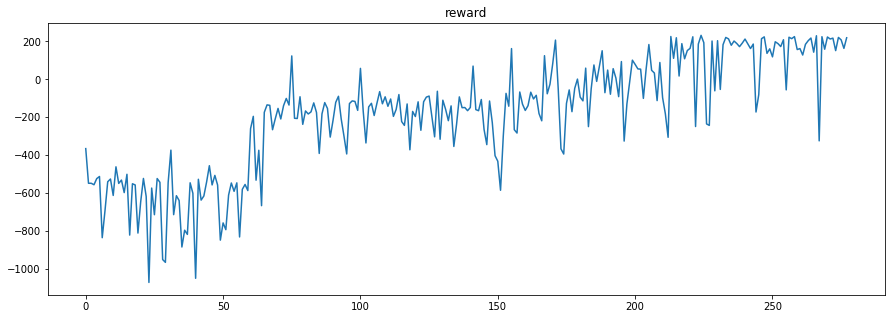

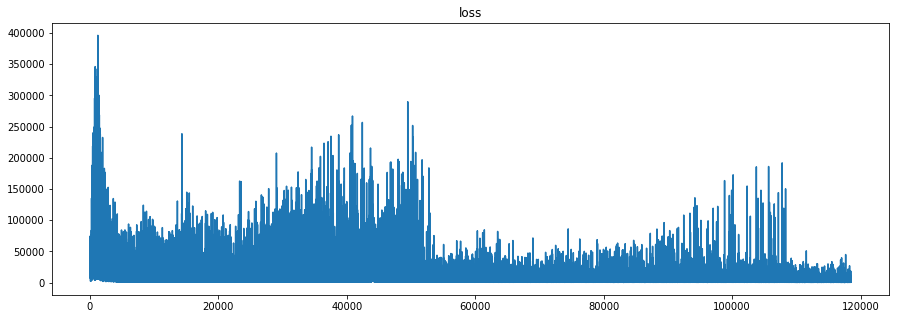

In [10]:
plt.figure(figsize=(15, 5))
plt.title('Reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('Loss')
plt.plot(losses)
plt.show()